In [1]:
import common

import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from dotenv import load_dotenv
from datetime import datetime
from zoneinfo import ZoneInfo
import wandb

In [2]:
common.wandb_login_init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/home/.netrc
wandb: Currently logged in as: kerneld82 (kerneld). Use `wandb login --relogin` to force relogin


train_time = 20240804-183122


In [3]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'datasets_fin/'

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
trn_img_size = 32
tst_img_size = 32
LR = 1e-3
EPOCHS = 1
BATCH_SIZE = 32
num_workers = 0
augment_ratio = 2
is_retrain_full_dataset = False # 최종 예측 시 전체 train 데이터로 재학습할지 여부

wandb.config.update({
    "learning_rate": LR,
    "architecture": model_name,
    "dataset": "custom-dataset",
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "train_image_size": trn_img_size,
    "test_image_size": tst_img_size,
    'augment_ratio' : augment_ratio,
    "is_retrain_full_dataset": is_retrain_full_dataset,
})

In [4]:
# 시드를 고정합니다.
SEED = 42

common.set_seed(SEED)

In [5]:
device

device(type='cuda')

### Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [6]:
trn_transform = common.create_trn_transform(trn_img_size)
trn_aug_transform = common.create_trn_aug_transform(trn_img_size)
tst_transform = common.create_tst_transform(tst_img_size)

In [7]:
# Dataset 정의
trn_dataset, val_dataset = common.train_dataset_split(
    "datasets_fin/train.csv",
    "datasets_fin/train/",
    trn_transform = trn_transform,
    trn_aug_transform = trn_aug_transform,
    tst_transform = tst_transform,
    augment_ratio = augment_ratio
)

tst_dataset = common.ImageDataset(
    "datasets_fin/sample_submission.csv",
    "datasets_fin/test/",
    transform = tst_transform
)

print("최종", len(trn_dataset), len(val_dataset), len(tst_dataset))

[dataset_split] 훈련 세트: 1099 샘플
[dataset_split] 검증 세트: 471 샘플
최종 2198 471 3140


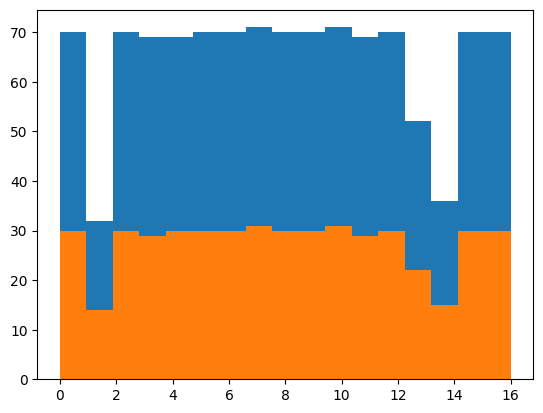

In [8]:
import matplotlib.pyplot as plt
plt.hist(trn_dataset.df[:,1], bins=17)
plt.hist(val_dataset.df[:,1], bins=17)
plt.show()

In [9]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [10]:
len(timm.list_models(pretrained=True))

1298

In [11]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [12]:
common.train_with_start_end_epoch(seed = SEED, 
                                  start_epoch_inclusive = 0, 
                                  end_epoch_exclusive = EPOCHS, 
                                  trn_loader = trn_loader, 
                                  val_loader = val_loader, 
                                  model = model, 
                                  model_name = model_name, 
                                  optimizer = optimizer, 
                                  loss_fn = loss_fn, 
                                  device = device, 
                                  is_save_model_checkpoint = True, 
                                  is_trn_full = False, 
                                  is_evaluate_train_valid = True)

Loss: 2.2467: 100%|██████████| 69/69 [00:10<00:00,  6.89it/s]


train_loss: 2.5699
train_acc: 0.1793
train_f1: 0.1623
epoch: 0.0000

Model checkpoint saved. filename: checkpoint-resnet34_epoch_0_False.pt



Evaluating: 100%|██████████| 15/15 [00:01<00:00,  9.12it/s]


final_train_loss: 2.1492318968841997
final_train_accuracy: 0.3257506824385805
final_train_f1: 0.31968209585451096
final_valid_loss: 1.7360326369603476
final_valid_accuracy: 0.46709129511677283
final_valid_f1: 0.4093102648760165


# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [13]:
if is_retrain_full_dataset:
    model, optimizer = common.retrain_full_dataset(seed = SEED,
                                                   epochs = EPOCHS,
                                                   trn_transform = trn_transform, 
                                                   trn_aug_transform = trn_aug_transform, 
                                                   augment_ratio = augment_ratio,
                                                   batch_size = BATCH_SIZE,
                                                   num_workers = num_workers,
                                                   model_name = model_name,
                                                   loss_fn = loss_fn,
                                                   lr = LR,
                                                   device = device)

In [14]:
common.pred_and_save_to_csv(model, tst_loader, device, "pred.csv")

100%|██████████| 99/99 [00:10<00:00,  9.16it/s]


In [15]:
# wandb 실행 종료
wandb.finish()

final_train_accuracy,▁
final_train_f1,▁
final_train_loss,▁
final_valid_accuracy,▁
final_valid_f1,▁
final_valid_loss,▁
train_acc,▁
train_f1,▁
train_loss,▁
final_train_accuracy,0.32575
final_train_f1,0.31968


In [16]:
import sys
sys.exit('아래 셀은 수동으로 실행하기 위해서 여기서 실행 멈춤.')

SystemExit: 아래 셀은 수동으로 실행하기 위해서 여기서 실행 멈춤.

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 수동으로 특정 체크포인트부터 이어서 학습하기 위한 부분


In [ ]:
next_epoch = common.load_model_checkpoint("checkpoint-resnet34_epoch_0_False.pt", model, optimizer)
next_epoch

1

In [ ]:
common.train_with_start_end_epoch(seed = SEED,
                           start_epoch_inclusive = next_epoch, 
                           end_epoch_exclusive = next_epoch + 2, 
                           trn_loader = trn_loader,
                           val_loader = val_loader,
                           model = model,
                           model_name = model_name,
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           device = device,
                           is_save_model_checkpoint = True,
                           is_trn_full = False,
                           is_evaluate_train_valid = True)

Loss: 1.9978: 100%|██████████| 69/69 [00:09<00:00,  7.39it/s]


train_loss: 2.0567
train_acc: 0.3367
train_f1: 0.3172
epoch: 1.0000

Model checkpoint saved. filename: checkpoint-resnet34_epoch_1_False.pt



Evaluating: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]



final_train_loss: 1.8334055240603462
final_train_accuracy: 0.41628753412192904
final_train_f1: 0.4238457127842959
final_valid_loss: 1.324286929766337
final_valid_accuracy: 0.5753715498938429
final_valid_f1: 0.5314120750651641




Loss: 1.6063: 100%|██████████| 69/69 [00:09<00:00,  7.43it/s]


train_loss: 1.7602
train_acc: 0.4304
train_f1: 0.4256
epoch: 2.0000

Model checkpoint saved. filename: checkpoint-resnet34_epoch_2_False.pt



Evaluating: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


final_train_loss: 1.5533669858738997
final_train_accuracy: 0.4959053685168335
final_train_f1: 0.5143541509652347
final_valid_loss: 0.9630688389142354
final_valid_accuracy: 0.70276008492569
final_valid_f1: 0.6736825114873417
